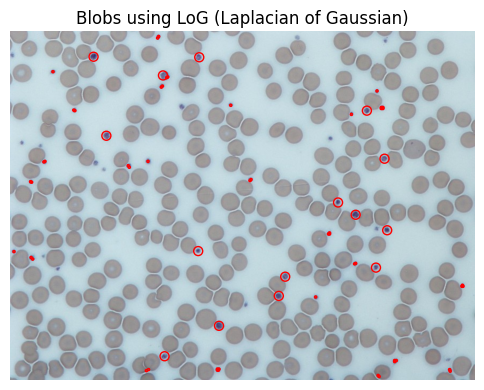

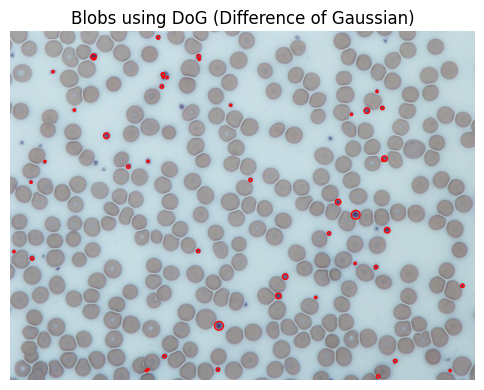

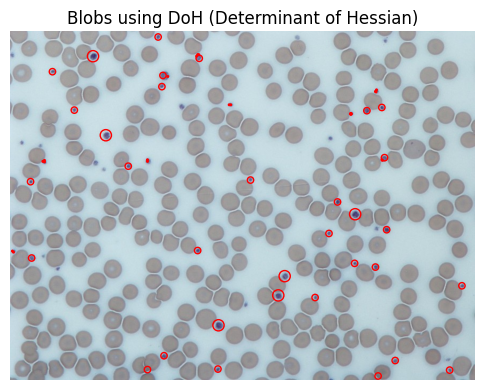

LoG blob count: 65
DoG blob count: 45
DoH blob count: 55


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.morphology import opening
from skimage.feature import blob_log, blob_dog, blob_doh
from math import sqrt

virus = imread('a.jpg')
gray = rgb2gray(virus)
binary = gray < 0.45
opened_image = opening(binary)

def show_blobs(image, blobs, title):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(image)
    for blob in blobs:
        y, x, r = blob
        ax.add_patch(plt.Circle((x, y), r * sqrt(2), color='red', fill=False))
    ax.set_title(title)
    ax.axis('off')
    plt.show()

blobs_log = blob_log(opened_image, min_sigma=1, max_sigma=30, num_sigma=10, threshold=0.1)
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
show_blobs(virus, blobs_log, "Blobs using LoG (Laplacian of Gaussian)")

blobs_dog = blob_dog(opened_image, min_sigma=1, max_sigma=30, sigma_ratio=1.6, threshold=0.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
show_blobs(virus, blobs_dog, "Blobs using DoG (Difference of Gaussian)")

blobs_doh = blob_doh(opened_image, min_sigma=1, max_sigma=30, threshold=0.01)
show_blobs(virus, blobs_doh, "Blobs using DoH (Determinant of Hessian)")

print(f"LoG blob count: {len(blobs_log)}")
print(f"DoG blob count: {len(blobs_dog)}")
print(f"DoH blob count: {len(blobs_doh)}")


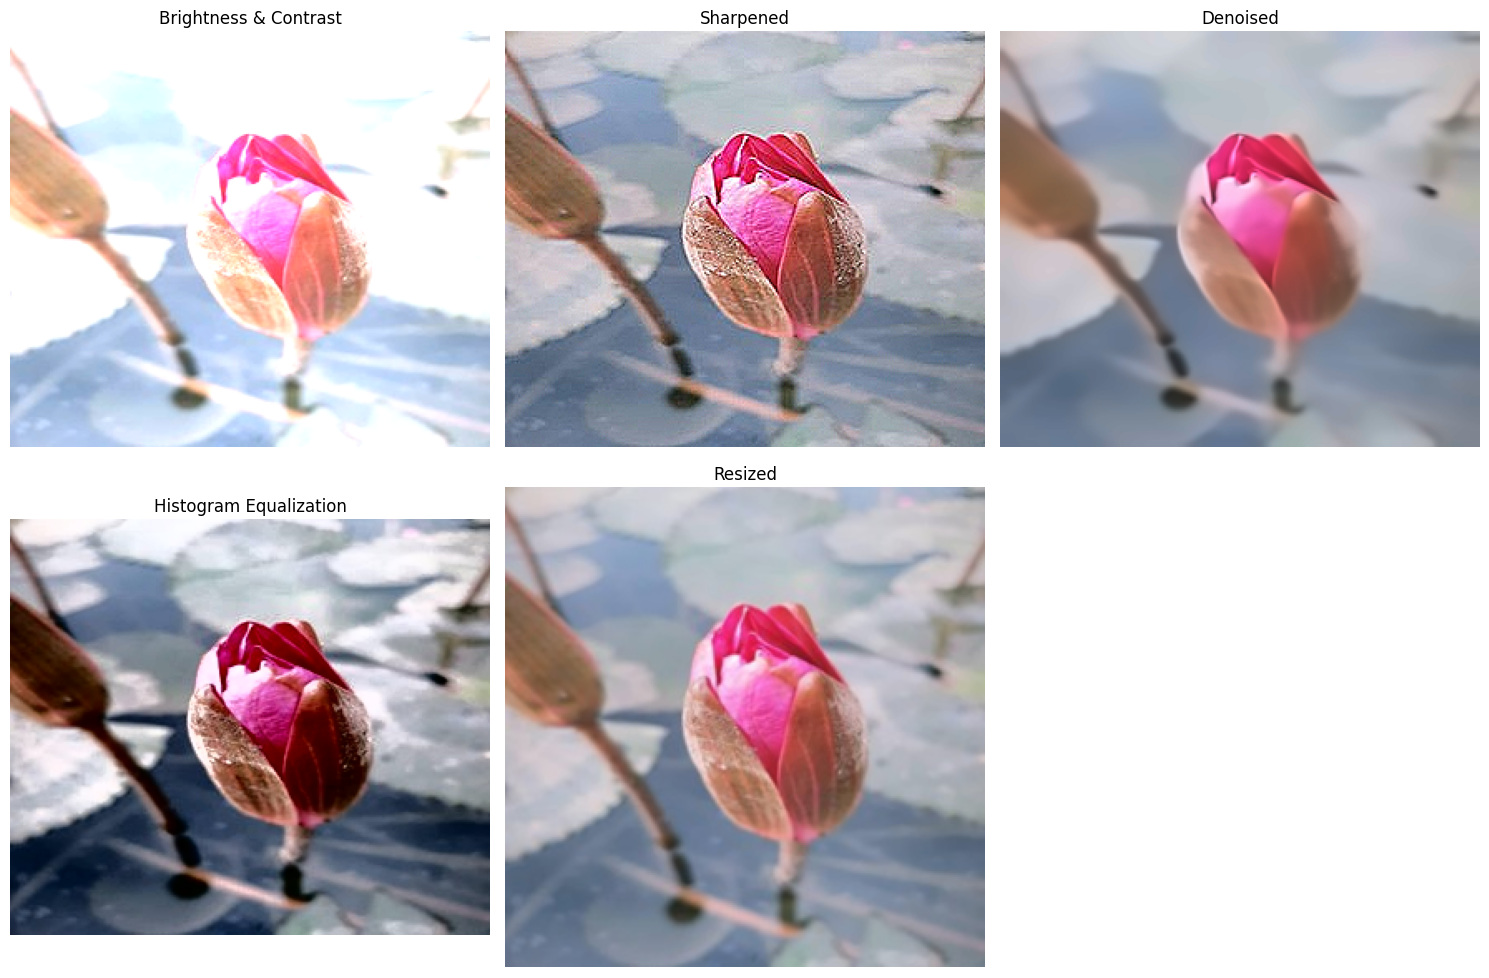

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "b.jpg"
image = cv2.imread(image_path)

bright_contrast = cv2.convertScaleAbs(image, alpha=1.5, beta=20)

kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharpened = cv2.filter2D(image, -1, kernel)

denoised = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])
equalized = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)

resized = cv2.resize(image, (256, 256))

def to_rgb(img): return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(to_rgb(bright_contrast)); axes[0, 0].set_title("Brightness & Contrast")
axes[0, 1].imshow(to_rgb(sharpened)); axes[0, 1].set_title("Sharpened")
axes[0, 2].imshow(to_rgb(denoised)); axes[0, 2].set_title("Denoised")
axes[1, 0].imshow(to_rgb(equalized)); axes[1, 0].set_title("Histogram Equalization")
axes[1, 1].imshow(to_rgb(resized)); axes[1, 1].set_title("Resized")
axes[1, 2].axis('off')

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import time

transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

alexnet = torchvision.models.alexnet(pretrained=True)
alexnet.classifier[6] = nn.Linear(4096, 100)

def train_model(model, trainloader, epochs=2):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
    model.train()

    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(trainloader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if batch_idx % 50 == 0:
                elapsed = time.time() - start_time
                eta = (elapsed / (batch_idx + 1)) * (len(trainloader) - batch_idx - 1)
                print(f"[Epoch {epoch+1}] Batch {batch_idx} - Loss: {running_loss/(batch_idx+1):.4f} | Time: {elapsed:.2f}s | ETA: {eta:.2f}s")

        print(f" Epoch {epoch+1} completed! Avg Loss: {running_loss/len(trainloader):.4f}")

    print(f" Training Completed in {time.time() - start_time:.2f} seconds")

print("\n Training Optimized AlexNet...")
train_model(alexnet, trainloader)

def evaluate_model(model, testloader):
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"\n📈 Optimized AlexNet Accuracy: {accuracy:.2f}%")

print("\n🔍 Evaluating Optimized AlexNet...")
evaluate_model(alexnet, testloader)


100%|██████████| 169M/169M [00:12<00:00, 13.4MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 219MB/s]



 Training Optimized AlexNet...
[Epoch 1] Batch 0 - Loss: 5.0410 | Time: 0.65s | ETA: 2044.62s
[Epoch 1] Batch 50 - Loss: 4.6510 | Time: 7.53s | ETA: 453.85s
[Epoch 1] Batch 100 - Loss: 4.6296 | Time: 14.14s | ETA: 423.34s
[Epoch 1] Batch 150 - Loss: 4.6226 | Time: 20.76s | ETA: 408.95s
[Epoch 1] Batch 200 - Loss: 4.6197 | Time: 27.53s | ETA: 400.52s
[Epoch 1] Batch 250 - Loss: 4.6180 | Time: 33.85s | ETA: 387.55s
[Epoch 1] Batch 300 - Loss: 4.6162 | Time: 40.61s | ETA: 381.03s
[Epoch 1] Batch 350 - Loss: 4.6141 | Time: 46.91s | ETA: 370.71s
[Epoch 1] Batch 400 - Loss: 4.6133 | Time: 53.64s | ETA: 364.39s
[Epoch 1] Batch 450 - Loss: 4.6126 | Time: 60.58s | ETA: 359.18s
[Epoch 1] Batch 500 - Loss: 4.6123 | Time: 67.32s | ETA: 352.58s
[Epoch 1] Batch 550 - Loss: 4.6118 | Time: 74.10s | ETA: 346.15s
[Epoch 1] Batch 600 - Loss: 4.6113 | Time: 80.39s | ETA: 337.62s
[Epoch 1] Batch 650 - Loss: 4.6106 | Time: 87.23s | ETA: 331.52s
[Epoch 1] Batch 700 - Loss: 4.6093 | Time: 93.59s | ETA: 323.6

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import time

transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(4096, 100)

def train_model(model, trainloader, epochs=2):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
    model.train()

    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(trainloader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if batch_idx % 50 == 0:
                elapsed = time.time() - start_time
                eta = (elapsed / (batch_idx + 1)) * (len(trainloader) - batch_idx - 1)
                print(f"[Epoch {epoch+1}] Batch {batch_idx} - Loss: {running_loss/(batch_idx+1):.4f} | Time: {elapsed:.2f}s | ETA: {eta:.2f}s")

        print(f" Epoch {epoch+1} completed! Avg Loss: {running_loss/len(trainloader):.4f}")

    print(f" Training Completed in {time.time() - start_time:.2f} seconds")

print("\n Training Optimized VGG16...")
train_model(vgg16, trainloader)

def evaluate_model(model, testloader):
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"\n📈 Optimized VGG16 Accuracy: {accuracy:.2f}%")

print("\n🔍 Evaluating Optimized VGG16...")
evaluate_model(vgg16, testloader)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 235MB/s]



 Training Optimized VGG16...
[Epoch 1] Batch 0 - Loss: 4.9193 | Time: 1.78s | ETA: 5567.38s
[Epoch 1] Batch 50 - Loss: 4.6503 | Time: 66.28s | ETA: 3995.16s
[Epoch 1] Batch 100 - Loss: 4.6304 | Time: 131.19s | ETA: 3927.79s
[Epoch 1] Batch 150 - Loss: 4.6228 | Time: 194.75s | ETA: 3835.59s
[Epoch 1] Batch 200 - Loss: 4.6129 | Time: 259.06s | ETA: 3768.65s
[Epoch 1] Batch 250 - Loss: 4.5829 | Time: 323.20s | ETA: 3700.67s
[Epoch 1] Batch 300 - Loss: 4.5401 | Time: 388.08s | ETA: 3641.03s
[Epoch 1] Batch 350 - Loss: 4.4682 | Time: 452.30s | ETA: 3574.56s
[Epoch 1] Batch 400 - Loss: 4.3987 | Time: 517.04s | ETA: 3512.24s
[Epoch 1] Batch 450 - Loss: 4.3046 | Time: 581.28s | ETA: 3446.42s
[Epoch 1] Batch 500 - Loss: 4.2100 | Time: 646.66s | ETA: 3386.88s
[Epoch 1] Batch 550 - Loss: 4.1415 | Time: 710.78s | ETA: 3320.41s
[Epoch 1] Batch 600 - Loss: 4.0633 | Time: 775.48s | ETA: 3256.76s
[Epoch 1] Batch 650 - Loss: 3.9956 | Time: 839.73s | ETA: 3191.23s
[Epoch 1] Batch 700 - Loss: 3.9257 | T